# A NOTEBOOK TO RUN NETWORK ANALYSIS ON SURFACE AREA DATA AVERAGED OVER CLUSTERS OF HCP PARCELS
Clusters of parcels are generated in R. Absolute surface area was averaged within the clusters and the data saved to the shared folder.

In [60]:
import itertools
# Import packages and scripts
import sys
from pathlib import Path
import pandas as pd
import scipy
from graph_tool.all import *
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import re
import scipy.stats as stats

common_path = Path("/workspace/scripts/common")
sys.path.append(str(common_path))
import networkfuncs # import networkfuncs script

We will convert our data to graphs and then plot the distributions of strengths for each group.

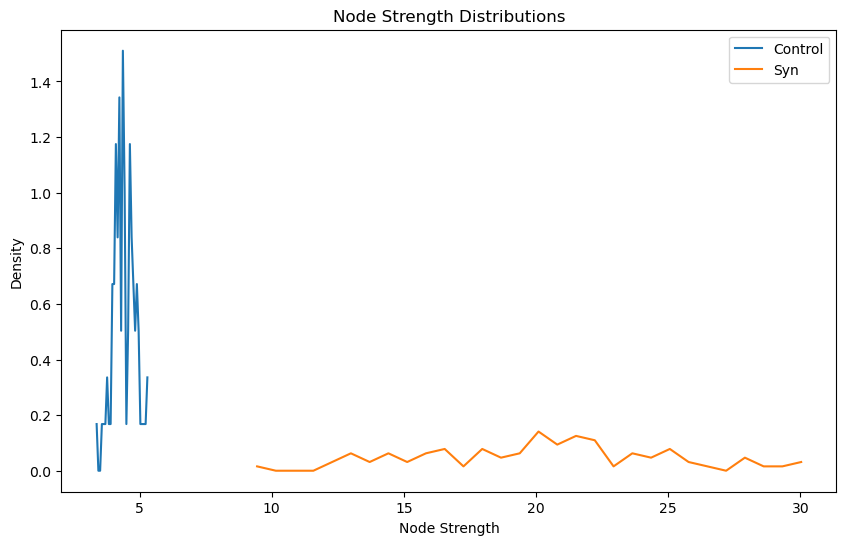

In [4]:
datapath = '/workspace/shared/synesthesia_100brains/surface_area/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_avg.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface area data averaged within 90 clusters. The clusters were identified from nearest neighbour joining of lr-averaged absolute surface area in 650 controls.

The node degree distributions look very different between groups. Will this be the same if we use resampled data from the controls so the sample sizes match?

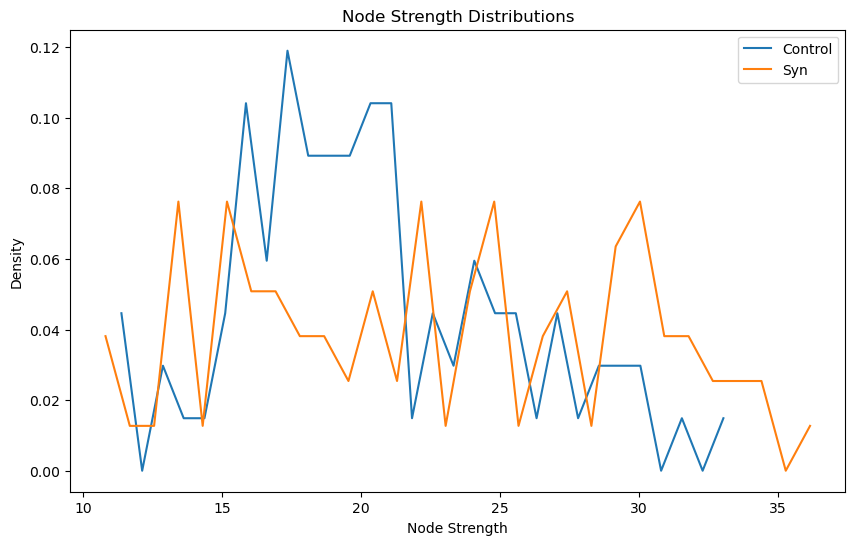

In [4]:
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_avg_resamp.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface areas averaged within clusters, but for 102 controls as well as 102 synesthetes.
NB: The clusters are still derived from the nearest neighbour clustering of the full 650 controls.

The strength distributions are more similar for this resampled data.
This suggests that even for a reduced number of nodes, partial correlations are still affected by sample size.
We should retry for a smaller number of nodes, obtained through a different clustering algorithm.

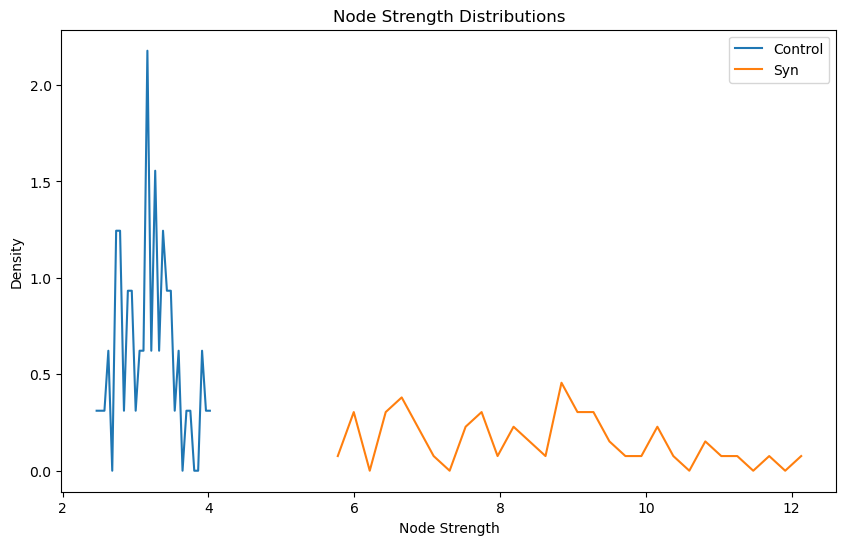

In [67]:
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_avg.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface area data averaged within 60 clusters. The clusters were identified from Ward's clustering of absolute surface area in 650 controls.

A very similar pattern to that observed with the 90 clusters. Let's try resampling again.

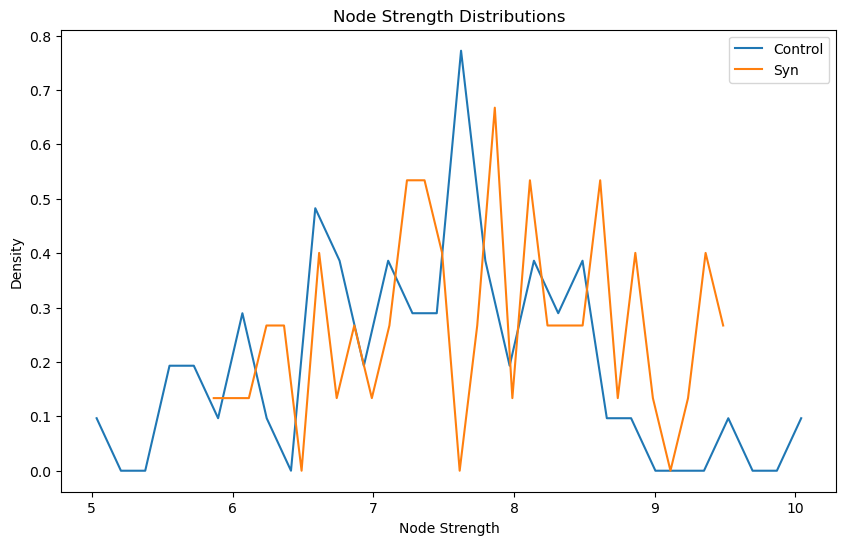

In [5]:
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_avg_resamp.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface areas averaged within clusters, but for 102 controls as well as 102 synesthetes.
NB: The clusters are still derived from the Ward's clustering of the full 650 controls.

Again, with resampling, the distributions now overlap. We can probably conclude that for any meaningful number of clusters - at least those obtained through hierarchical clustering - we will probably have to resample the control group to avoid mismatched comparisons between the two groups. From here, let's try running some graph analysis on the nearest neighbour cluster data (90 clusters).

   clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0    0.263412    0.292612  1.909798  0.000401  0.006892  Control
1    0.266221    0.293325  1.902216  0.000398  0.006770      Syn


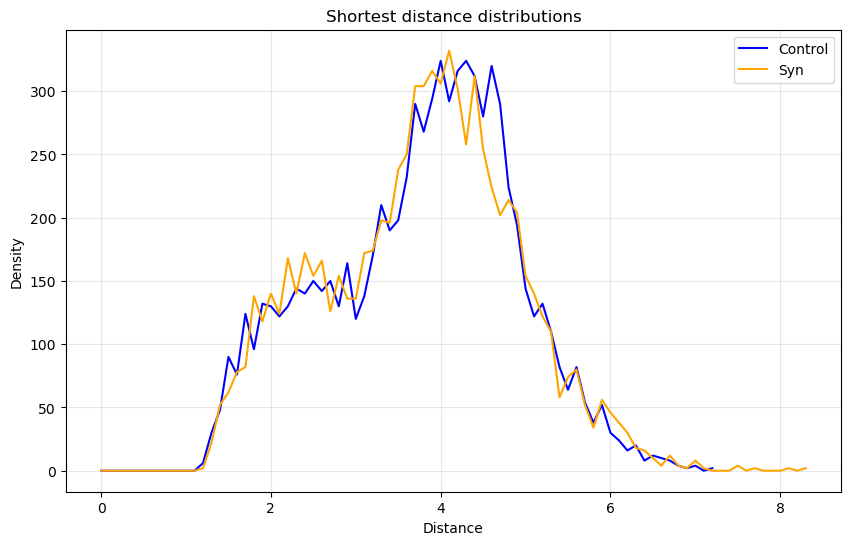

In [3]:
# Re-generate the desired graphs and get the network metrics
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_avg_resamp.csv', 'Syn') # re-generate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control', 'Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results

plt.figure(figsize=(10, 6))

plt.plot(dist_hists[0][1][:-1], dist_hists[0][0], label="Control", color="blue")
plt.plot(dist_hists[1][1][:-1], dist_hists[1][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

No clear differences between the control sample and synesthetes.

We should see if this holds for various resamples of the control dataset.

In [24]:
# Read data and generate graphs for controls and synesthetes
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
files = listdir(datapath)
cntrl_resamp = [str(file) for file in files if re.search('nn90_sum_cntrl_resamp_[0-9]*.csv$', file)]
graphs_control = []
for file in cntrl_resamp:
    graphs_control.append(networkfuncs.data_to_graphs(datapath+file))
    
graph_syn = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_sum_syn.csv')

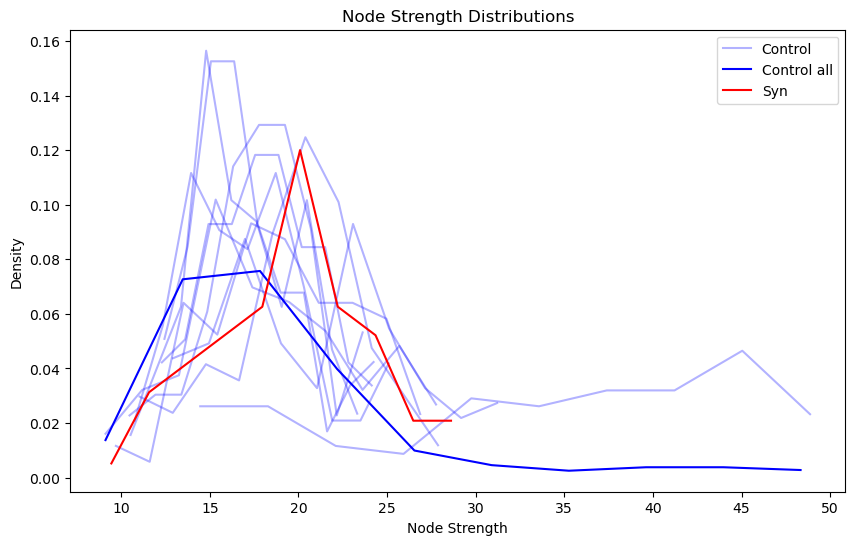

In [25]:
# Plot strength distributions
strengths_control = []
for graph in graphs_control: # for each graph
    weight = graph.edge_properties["weight"] # get edge weights
    strengths_control.append(graph.degree_property_map("total", weight = weight).a) # get total weight for each vertex
    
strengths_syn = graph_syn.degree_property_map("total", weight = graph_syn.edge_properties["weight"]).a # get syn strengths

fig = plt.figure(figsize=(10, 6)) # initialise figure
ax = fig.add_subplot(1, 1, 1) # add a single panel
for strength in strengths_control:   
    counts, bins = np.histogram(strength, bins=10, density=True)  # get the histogram of control strengths
    plt.plot(bins[:-1], counts, label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", alpha = 0.3, color = 'blue') # plot histograms
counts_mean, bins_mean = np.histogram(np.concat(strengths_control), bins=10, density=True) # get histogram of all control strengths
plt.plot(bins_mean[:-1], counts_mean, label="Control all", alpha = 1, color = 'blue') # plot histogram
counts, bins = np.histogram(strengths_syn, bins=10, density=True)  # get the histogram of synesthete strengths
plt.plot(bins[:-1], counts, label='Syn', color = 'red') # plot histogram
fig.set_facecolor('white') # make background white
ax.set_facecolor('white') # make background white
plt.xlabel("Node Strength") # x-axis title
plt.ylabel("Density") # y-axis title
plt.legend() # show the legend
plt.title("Node Strength Distributions") # set the title
plt.show() # show plot

    clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0     0.263412    0.292612  1.909798  0.000401  0.006892  Control
1     0.223705    0.264221  2.078505  0.000406  0.007122  Control
2     0.231760    0.271517  2.029384  0.000398  0.006770  Control
3     0.262191    0.298972  1.854177  0.000398  0.006761  Control
4     0.290294    0.307191  1.819079  0.000391  0.006412  Control
5     0.233215    0.275290  2.001645  0.000403  0.006983  Control
6     0.267118    0.287303  1.961885  0.000405  0.007048  Control
7     0.221868    0.264276  2.083110  0.000406  0.007099  Control
8     0.229743    0.263530  2.094754  0.000403  0.006991  Control
9     0.499187    0.443540  1.325064  0.000341  0.004160  Control
10    0.266221    0.293325  1.902216  0.000398  0.006770      Syn
         clustering  efficiency     L_obs   mean_eb   mean_vb
Group                                                        
Control    0.272249    0.296845  1.915740  0.000395  0.006624
Syn        0.266221   

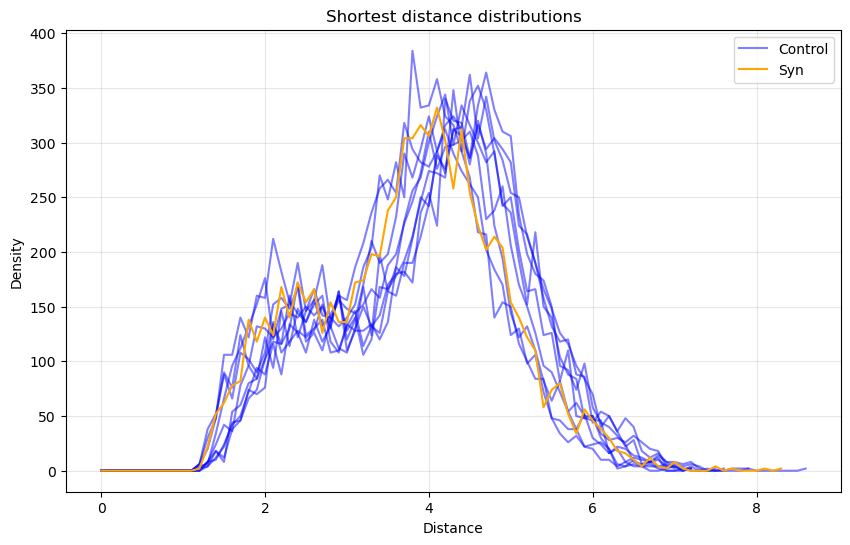

In [26]:
# Get network metrics
graphs = graphs_control + [graph_syn] # concatenate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control'] * 10 + ['Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results
print(net_metrics.groupby('Group').mean()) # print averaged results

plt.figure(figsize=(10, 6))

# below needs to change to get all controls
for hist in dist_hists[0:9]:
    plt.plot(hist[1][:-1], hist[0], label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", color="blue", alpha = 0.5)

plt.plot(dist_hists[10][1][:-1], dist_hists[10][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Again, no clear differences here between the control resamples and the synesthete group.

Let's try with 60 clusters derived from level 2 of Ward's clustering.

In [65]:
# Read data and generate graphs for controls and synesthetes
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
files = listdir(datapath)
cntrl_resamp = [str(file) for file in files if re.search('wrd60_sum_cntrl_resamp_[0-9]*.csv$', file)]
graphs_control = []
for file in cntrl_resamp:
    graphs_control.append(networkfuncs.data_to_graphs(datapath+file))
    
graph_syn = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_sum_syn.csv')

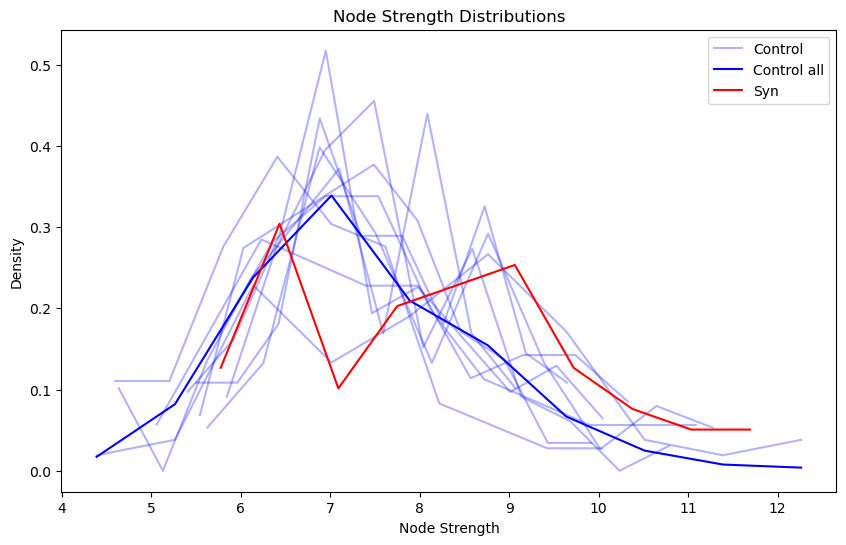

In [66]:
# Plot strength distributions
strengths_control = []
for graph in graphs_control: # for each graph
    weight = graph.edge_properties["weight"] # get edge weights
    strengths_control.append(graph.degree_property_map("total", weight = weight).a) # get total weight for each vertex
    
strengths_syn = graph_syn.degree_property_map("total", weight = graph_syn.edge_properties["weight"]).a # get syn strengths

fig = plt.figure(figsize=(10, 6)) # initialise figure
ax = fig.add_subplot(1, 1, 1) # add a single panel
for strength in strengths_control:   
    counts, bins = np.histogram(strength, bins=10, density=True)  # get the histogram of control strengths
    plt.plot(bins[:-1], counts, label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", alpha = 0.3, color = 'blue') # plot histograms
counts_mean, bins_mean = np.histogram(np.concat(strengths_control), bins=10, density=True) # get histogram of all control strengths
plt.plot(bins_mean[:-1], counts_mean, label="Control all", alpha = 1, color = 'blue') # plot histogram
counts, bins = np.histogram(strengths_syn, bins=10, density=True)  # get the histogram of synesthete strengths
plt.plot(bins[:-1], counts, label='Syn', color = 'red') # plot histogram
fig.set_facecolor('white') # make background white
ax.set_facecolor('white') # make background white
plt.xlabel("Node Strength") # x-axis title
plt.ylabel("Density") # y-axis title
plt.legend() # show the legend
plt.title("Node Strength Distributions") # set the title
plt.show() # show plot

    clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0     0.132217    0.174080  3.168569  0.000957  0.011972  Control
1     0.158685    0.192365  2.878999  0.000943  0.011533  Control
2     0.139519    0.178957  3.078852  0.000940  0.011455  Control
3     0.133653    0.176742  3.107142  0.000953  0.011855  Control
4     0.141395    0.183446  3.015299  0.000970  0.012351  Control
5     0.138315    0.178250  3.087703  0.000951  0.011777  Control
6     0.143575    0.180096  3.072914  0.000956  0.011933  Control
7     0.150629    0.190954  2.885978  0.000960  0.012049  Control
8     0.126423    0.166252  3.322822  0.000974  0.012498  Control
9     0.145156    0.180795  3.058284  0.000949  0.011728  Control
10    0.158719    0.193442  2.859631  0.000934  0.011270      Syn
         clustering  efficiency     L_obs   mean_eb   mean_vb
Group                                                        
Control    0.140957    0.180194  3.067656  0.000955  0.011915
Syn        0.158719   

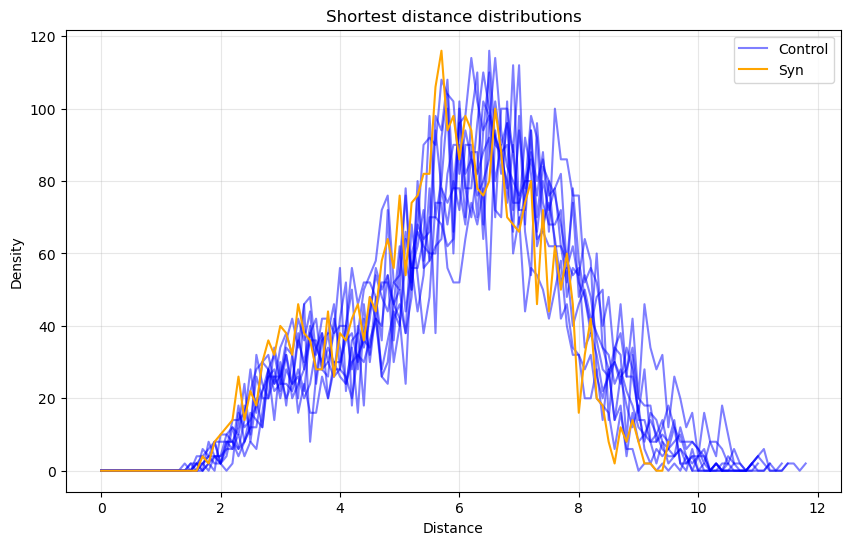

In [67]:
# Get network metrics
graphs = graphs_control + [graph_syn] # concatenate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control'] * 10 + ['Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results
print(net_metrics.groupby('Group').mean()) # print averaged results

plt.figure(figsize=(10, 6))

# below needs to change to get all controls
for hist in dist_hists[0:9]:
    plt.plot(hist[1][:-1], hist[0], label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", color="blue", alpha = 0.5)

plt.plot(dist_hists[10][1][:-1], dist_hists[10][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Perhaps some small differences here? Let's test it out.

In [68]:
# T-test and effect sizes
def cohen_d_one(x,y):
    return (np.mean(x) - np.mean(y)) / (np.std(x, ddof=1))

print(cohen_d_one(x = net_metrics['clustering'][net_metrics['Group'] == 'Control'], y = net_metrics['clustering'][net_metrics['Group'] == 'Syn']))
print(stats.ttest_1samp(net_metrics['clustering'][net_metrics['Group'] == 'Control'], net_metrics['clustering'][net_metrics['Group'] == 'Syn']))

-1.9048904037405567
TtestResult(statistic=np.float64(-6.023792368817887), pvalue=np.float64(0.00019668333427108758), df=np.int64(9))


# Network analysis of 90 spectral clusters
In testing in R, we found that spectral clustering performed better than both nearest-neighbour with 90 clusters and Ward's hierarchical clustering with 60 clusters. Let's import the data and run the network analysis.

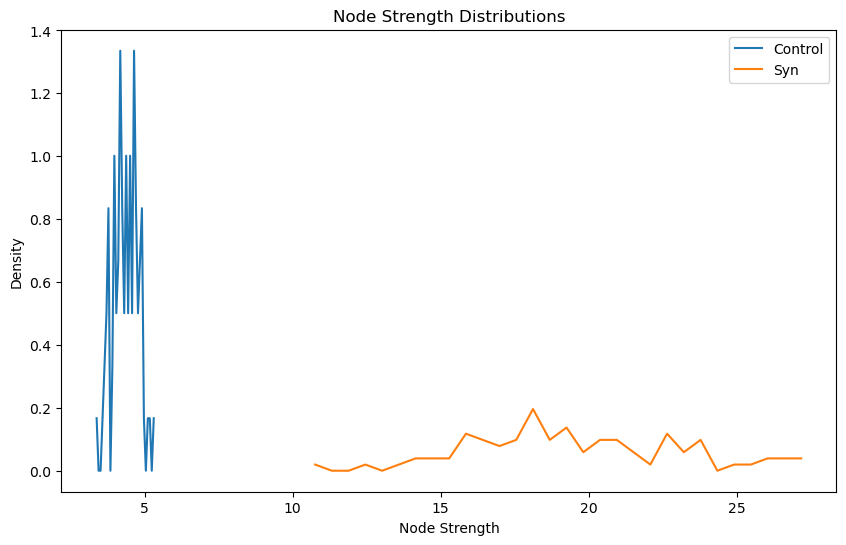

In [53]:
datapath = '/workspace/shared/synesthesia_100brains/surface_area/spectral_clust/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_spec90_avg.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface area data averaged within 90 clusters. The clusters were identified using spectral clustering of lr-averaged data in 650 controls.

Again with the spectral clustering, we will have to use resampled controls. Let's import 10 sets of resamples for statistical support.

In [54]:
# Read data and generate graphs for controls and synesthetes
files = listdir(datapath)
cntrl_resamp = [str(file) for file in files if re.search('spec90_sum_cntrl_resamp_[0-9]*.csv$', file)]
graphs_control = []
for file in cntrl_resamp:
    graphs_control.append(networkfuncs.data_to_graphs(datapath+file))
    
graph_syn = networkfuncs.data_to_graphs(datapath+'SA_abs_spec90_sum_syn.csv')

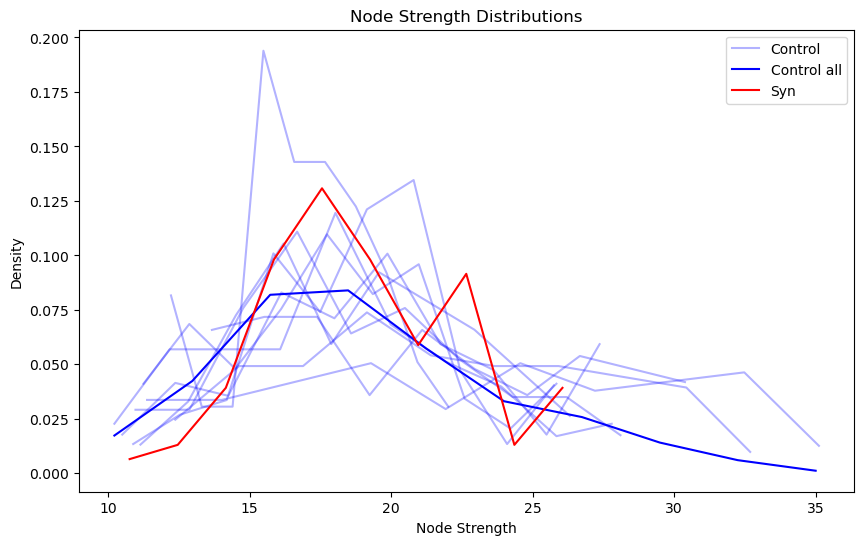

In [55]:
# Plot strength distributions
strengths_control = []
for graph in graphs_control: # for each graph
    weight = graph.edge_properties["weight"] # get edge weights
    strengths_control.append(graph.degree_property_map("total", weight = weight).a) # get total weight for each vertex
    
strengths_syn = graph_syn.degree_property_map("total", weight = graph_syn.edge_properties["weight"]).a # get syn strengths

fig = plt.figure(figsize=(10, 6)) # initialise figure
ax = fig.add_subplot(1, 1, 1) # add a single panel
for strength in strengths_control:   
    counts, bins = np.histogram(strength, bins=10, density=True)  # get the histogram of control strengths
    plt.plot(bins[:-1], counts, label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", alpha = 0.3, color = 'blue') # plot histograms
counts_mean, bins_mean = np.histogram(np.concat(strengths_control), bins=10, density=True) # get histogram of all control strengths
plt.plot(bins_mean[:-1], counts_mean, label="Control all", alpha = 1, color = 'blue') # plot histogram
counts, bins = np.histogram(strengths_syn, bins=10, density=True)  # get the histogram of synesthete strengths
plt.plot(bins[:-1], counts, label='Syn', color = 'red') # plot histogram
fig.set_facecolor('white') # make background white
ax.set_facecolor('white') # make background white
plt.xlabel("Node Strength") # x-axis title
plt.ylabel("Density") # y-axis title
plt.legend() # show the legend
plt.title("Node Strength Distributions") # set the title
plt.show() # show plot

    clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0     0.294749    0.311685  1.794946  0.000391  0.006415  Control
1     0.335721    0.330681  1.719671  0.000385  0.006180  Control
2     0.306349    0.321012  1.748817  0.000391  0.006424  Control
3     0.252614    0.286859  1.929148  0.000399  0.006795  Control
4     0.243787    0.284093  1.938363  0.000400  0.006827  Control
5     0.257886    0.284172  1.959948  0.000399  0.006793  Control
6     0.242104    0.276364  2.005258  0.000402  0.006954  Control
7     0.251413    0.277013  2.009913  0.000400  0.006852  Control
8     0.267692    0.292976  1.908289  0.000402  0.006937  Control
9     0.214635    0.264547  2.068947  0.000408  0.007221  Control
10    0.250211    0.289009  1.915005  0.000400  0.006832      Syn
         clustering  efficiency     L_obs   mean_eb   mean_vb
Group                                                        
Control    0.266695    0.292940  1.908330  0.000398  0.006740
Syn        0.250211   

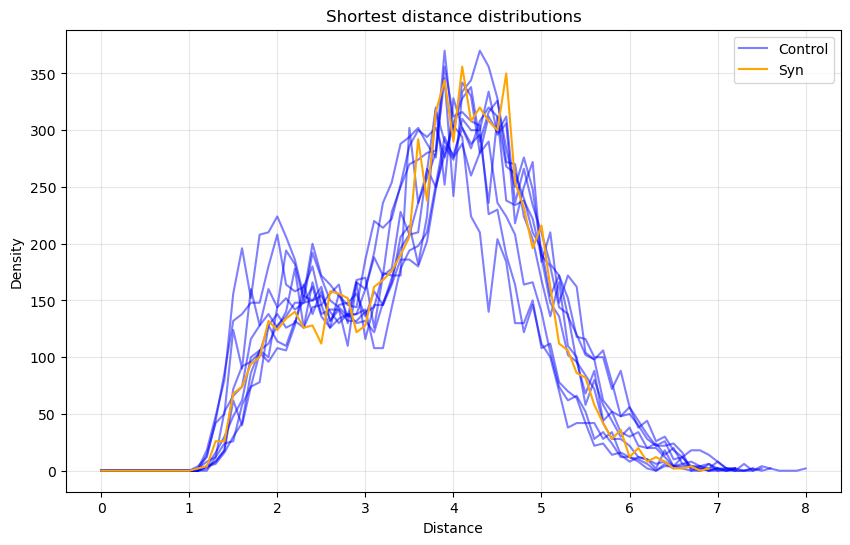

In [56]:
# Get network metrics
graphs = graphs_control + [graph_syn] # concatenate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control'] * 10 + ['Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results
print(net_metrics.groupby('Group').mean()) # print averaged results

plt.figure(figsize=(10, 6))

# below needs to change to get all controls
for hist in dist_hists[0:9]:
    plt.plot(hist[1][:-1], hist[0], label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", color="blue", alpha = 0.5)

plt.plot(dist_hists[10][1][:-1], dist_hists[10][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

We don't see any meaningful differences here with the 90 spectral clusters, when data is summed or averaged within clusters. Re-running with 60 clusters instead of 90 also makes no change, other than reducing the metrics across the board.